# Problem statemen:
A very basic cat not a cat image recognition. this was taken from the C1W4 DL specialization's last assignment, but doing it using tf instead of coding it using only numpy.

In [1]:
# Importing packages:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# Loading the data:

def load_data():
    train_dataset = h5py.File('../Datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../Datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [3]:
# exploring the data:

print(f'train_x_orig shape: {train_x_orig.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x_orig shape: {test_x_orig.shape}')
print(f'test_y shape: {test_y.shape}')

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


We have 209 training examples, and 50 testing examples, each of them is a 64 * 64 * 3 picture.
We need to flatten them for further analysis.

In [4]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
x_train = train_x_orig.reshape(209,-1)
x_test = test_x_orig.reshape(50,-1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (209, 12288)
x_test shape: (50, 12288)


displaying 16 random images of the data:

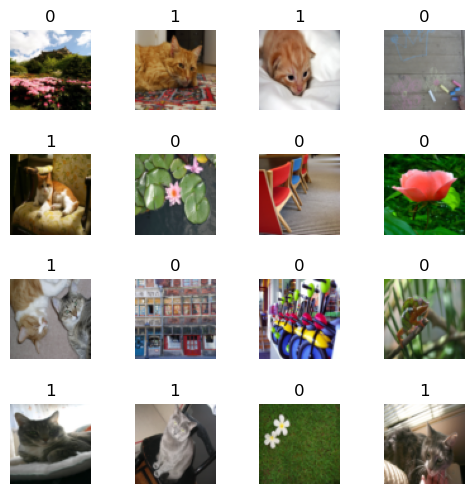

In [6]:
m,n = x_train.shape

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    ax.imshow(x_train[rand].reshape(64,64,3), cmap='gray')
    ax.set_title(train_y.T[rand][0])
    ax.set_axis_off()

In [7]:
# feature scaling:
x_test = x_test/255
x_train = x_train/255

## Logistic Regression:

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(x_train, train_y.T.ravel())

LogisticRegression(max_iter=500)

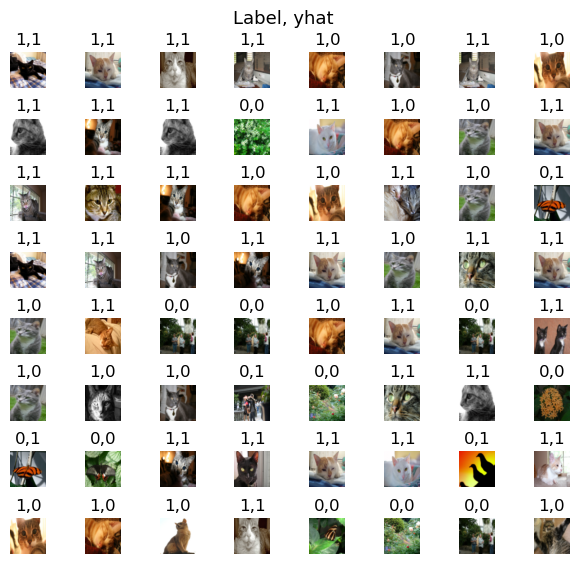

In [9]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [10]:
prediction=np.zeros(x_test.shape[0])
for i in range(50):
    predict = model.predict(x_test[i].reshape(1,12288))
    if predict >= 0.5:
        yhat=1
    else:
        yhat=0
    prediction[i] = yhat

prediction

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.])

In [11]:
test_y.shape

(1, 50)

In [12]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction.ravel(),test_y.T)
acc

0.72

We achieved 72% accuracy using logistic regression.

## Neural Networks:

In [13]:
regularizer = tf.keras.regularizers.L2(0.5)

model = tf.keras.models.Sequential([
                                    tf.keras.Input(shape=(12288,)),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(units=70, activation='relu'),# kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(units=15, activation='relu'),# kernel_regularizer=regularizer),
                                    tf.keras.layers.Dense(units=1, activation='sigmoid')
                                    ])
        
                

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 70)                860230    
                                                                 
 dense_1 (Dense)             (None, 15)                1065      
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 861,311
Trainable params: 861,311
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.000007),
              metrics='accuracy'
             )

In [17]:
history = model.fit(x_train, 
                    train_y.T,
                    epochs=500,
                   validation_data = (x_test, test_y.T))

Epoch 1/500
7/7 [==============================] - 1s 49ms/step - loss: 0.6805 - accuracy: 0.5837 - val_loss: 0.8241 - val_accuracy: 0.3800
Epoch 2/500
7/7 [==============================] - 0s 20ms/step - loss: 0.6542 - accuracy: 0.6364 - val_loss: 0.8364 - val_accuracy: 0.3600
Epoch 3/500
7/7 [==============================] - 0s 19ms/step - loss: 0.6607 - accuracy: 0.6364 - val_loss: 0.8473 - val_accuracy: 0.3600
Epoch 4/500
7/7 [==============================] - 0s 19ms/step - loss: 0.6637 - accuracy: 0.6220 - val_loss: 0.8256 - val_accuracy: 0.3600
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 0.6572 - accuracy: 0.6220 - val_loss: 0.7850 - val_accuracy: 0.3800
Epoch 6/500
7/7 [==============================] - 0s 22ms/step - loss: 0.6614 - accuracy: 0.6459 - val_loss: 0.8023 - val_accuracy: 0.3800
Epoch 7/500
7/7 [==============================] - 0s 21ms/step - loss: 0.6339 - accuracy: 0.6316 - val_loss: 0.8302 - val_accuracy: 0.3600
Epoch 8/500
7/7 [===

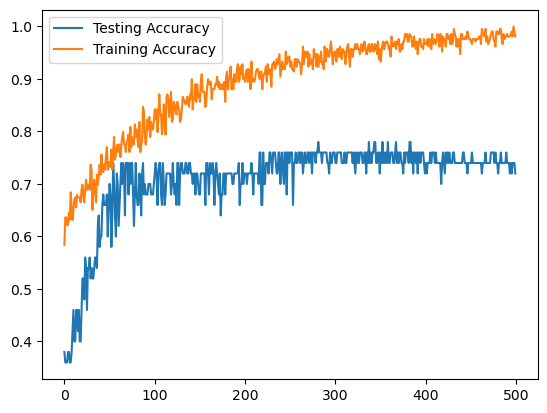

In [18]:
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()

In [ ]:
fig, ax = plt.subplots(8,8, figsize=(6,6))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92])
m,n = x_test.shape

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    prediction = model.predict(x_test[rand].reshape(1,12288))
    if prediction >= 0.5:
        yhat=1
    else:
        yhat=0
    
    ax.imshow(x_test[rand].reshape(64,64,3))
    true = test_y.T[rand][0]
    ax.set_title(f'{true},{yhat}')
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=13);

In [ ]:
model.evaluate(x_test,test_y.T)

We increased the accuracy to 78%.